In [ ]:
# default_exp samplers

# Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction circuits

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash, unpack
from qsam.fault_generators import Depolar
from qsam.protocol import iterate

import numpy as np
import itertools as it
import networkx as nx

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}
MEAS_GATES = {'measure'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES | MEAS_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES,
               'p_meas': MEAS_GATES
               }

In [ ]:
#export
class Sampler:
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))

        # self.p_phy_per_partition = np.vstack(list(err_params.values())).T
        # self.partitions = map_dict(protocol._circuits, lambda _,circuit: [partition(circuit, GATE_GROUPS[g]) for g in err_params.keys()])
        # self.fault_gens = map_dict(protocol._circuits, lambda _,circuit: Depolar(len(circuit)))

                         
    def run(self, n_samples, sample_range, err_params, var=math.Wilson_var, eval_fns=None):
        # fail_cnts = np.zeros((self.p_phy_per_partition.shape[0])) # one fail counter per p_phys
        fail_cnts = np.zeros(len(sample_range)) # one fail counter per sample point
        
        # for i, p_phy in enumerate(self.p_phy_per_partition):
        
        for i,sample_pt in enumerate(sample_range): # n_samples at sample_pt
            
            p_phy = np.array(list(err_params.values())) * sample_pt
            
            for _ in range(n_samples):
                
                sim = self.simulator(self.n_qubits)
                p_it = iterate(self.protocol, eval_fns)
                node = next(p_it)
                
                while node:
                    
                    if node == 'EXIT':
                        fail_cnts[i] += 1
                        break
                    else:
                        circuit = self.protocol.circuit_from_node(node)
                        partitions = [partition(circuit, GATE_GROUPS[k]) for k in err_params.keys()] # => some kind of cache to not calc every time anew!
                        faults = Depolar.faults_from_probs(partitions, p_phy)
                        fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                        msmt = sim.run(circuit, fault_circuit)
                        node = p_it.send(msmt)
                    
        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

We are going to test the direct Monte Carlo sampler on the simple GHZ state preparation flag circuit. 

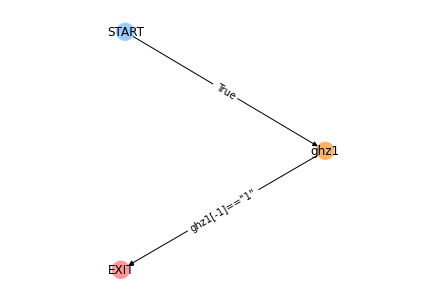

In [ ]:
from qsam.protocol import Protocol, draw_protocol, iterate
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

ghz1 = Protocol()
ghz1.add_nodes_from(['ghz1'], circuits=ghz)
ghz1.add_edge('START', 'ghz1', check='True')
ghz1.add_edge('ghz1', 'EXIT', check='ghz1[-1]=="1"')
draw_protocol(ghz1)

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = Sampler(ghz1, CHP)
p_L, std = sam.run(1000, sample_range, err_params)

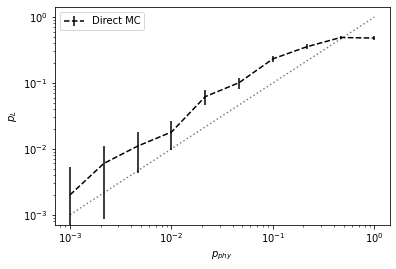

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

p = sample_range

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$p_{phy}$')
plt.legend();

Other more complex protocols:

1. GHZ repeat-until-success (indefinitely)

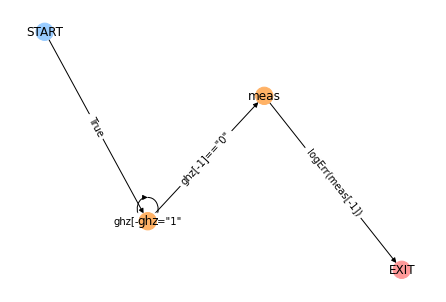

In [ ]:
from qsam.protocol import Protocol, draw_protocol, iterate
from qsam.circuit import Circuit

ghz = Circuit([ {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

meas = Circuit([ {"measure": {0,1,2,3}} ])

def logErr(m):
    return True if int(m,2)==1 else False

functions = {'logErr': logErr}

g = Protocol()
g.add_nodes_from(['ghz', 'meas'], circuits=[ghz, meas])
g.add_edge('START', 'ghz', check='True')
g.add_edge('ghz', 'ghz', check='ghz[-1]=="1"')
g.add_edge('ghz', 'meas', check='ghz[-1]=="0"')
g.add_edge('meas', 'EXIT', check='logErr(meas[-1])')
draw_protocol(g)

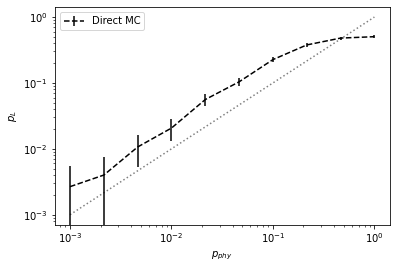

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = Sampler(ghz1, CHP)
p_L, std = sam.run(1500, sample_range, err_params)

import matplotlib.pyplot as plt

p = sample_range

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$p_{phy}$')
plt.legend();

2. Flag Stab. protocol `det0FT`

In [ ]:
from qsam.protocol import Protocol, draw_protocol, iterate
from qsam.circuit import Circuit

eft = Circuit([ {"init": {0,1,2,4,3,5,6,7}},
                {"H": {1,2,4}},
                {"CNOT": {(0,4)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(3,5)}},
                {"CNOT": {(0,6)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(1,5)}},
                {"CNOT": {(0,2)}},
                {"CNOT": {(5,6)}},
                {"CNOT": {(4,7)}},
                {"CNOT": {(2,7)}},
                {"CNOT": {(5,7)}},
                {"measure": {7}} ])

sz_2 = Circuit([{"init": {8}},
                {"CNOT": {(0,8)}},
                {"CNOT": {(2,8)}},
                {"CNOT": {(4,8)}},
                {"CNOT": {(6,8)}},
                {"measure": {8}}])

sz_3 = Circuit([{"init": {8}},
                {"CNOT": {(1,8)}},
                {"CNOT": {(2,8)}},
                {"CNOT": {(5,8)}},
                {"CNOT": {(6,8)}},
                {"measure": {8}}])

meas = Circuit([ {"measure": {0,1,2,3,4,5,6}} ])

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]


def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):    
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')
        
def flagged_z_look_up_table_2(z,flag):
    s = [z,flag]
    if np.sum(s) > 0:
                
        if s == [0,1]:
            return Circuit([{'X': {0,2}}])
        elif s == [1,0]:
            return Circuit([{'X': {5,6}}])
        elif s == [1,1]:
            return Circuit([{'X': {2}}])
        else: 
            return Circuit()

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_2}

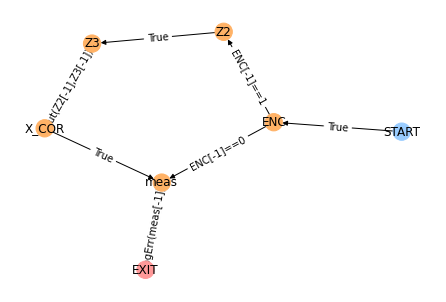

In [ ]:
init = Protocol()
init.add_nodes_from(['ENC', 'Z2', 'Z3', 'meas'], circuits=[eft, sz_2, sz_3, meas])
init.add_node('X_COR', circuit=Circuit())

init.add_edge('START', 'ENC', check='True')

init.add_edge('ENC', 'meas', check='ENC[-1]==0')

init.add_edge('ENC', 'Z2', check='ENC[-1]==1')
init.add_edge('Z2', 'Z3', check='True')
init.add_edge('Z3', 'X_COR', check='lut(Z2[-1],Z3[-1])')

init.add_edge('X_COR', 'meas', check='True')

init.add_edge('meas', 'EXIT', check='logErr(meas[-1])')

init.add_edge('meas', 'EXIT', check='logErr(meas[-1])')
draw_protocol(init)

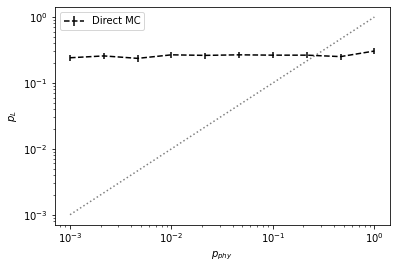

In [ ]:
#slow

p = np.logspace(-3,0,10)
err_params = {'p1': 0.0045, 'p2': 0.025}

from qsam.simulators.chp import ChpSimulator as CHP

sam = Sampler(init, CHP)
p_L, std = sam.run(n_samples=1000, sample_range=p, err_params=err_params, eval_fns=functions)

import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$p_{phy}$')
plt.legend();

3. Complex flagged stabilizer protocol `flagstabinit`

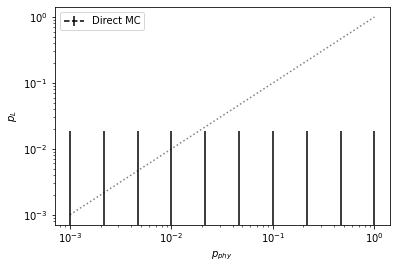

In [ ]:
#slow

fmx_1 = Circuit([{"init": {8}},
                 {"H": {8}},
                {"init": {9}},
                {"CNOT": {(8,3)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,4)}},
                {"CNOT": {(8,5)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,6)}},
                 {"H": {8}},
                {"measure": {8}},
                {"H": {8}},
                {"measure": {9}} ])

fmx_2 = Circuit([{"init": {8}},
                  {"H": {8}},
                {"init": {9}},
                {"CNOT": {(8,0)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,2)}},
                {"CNOT": {(8,4)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,6)}},
                 {"H": {8}},
                {"measure": {8}},
                {"H": {8}},
                {"measure": {9}} ])

fmx_3 = Circuit([{"init": {8}},
              {"H": {8}},
                {"init": {9}},
                {"CNOT": {(8,1)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,2)}},
                {"CNOT": {(8,5)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,6)}},
                 {"H": {8}},
                {"measure": {8}},
                {"H": {8}},
                {"measure": {9}} ])

nfs = Circuit([{"init": {7,8,9}},
               {"H": {7,8,9}},
                {"CNOT": {(7,3)}},
                {"CNOT": {(7,4)}},
                {"CNOT": {(7,5)}},
                {"CNOT": {(7,6)}},
                {"CNOT": {(8,0)}},
                {"CNOT": {(8,2)}},
                {"CNOT": {(8,4)}},
                {"CNOT": {(8,6)}},
                {"CNOT": {(9,1)}},
                {"CNOT": {(9,2)}},
                {"CNOT": {(9,5)}},
                {"CNOT": {(9,6)}},
                {"H": {7,8,9}},
                {"measure": {7,8,9}},
                {"H": {7,8,9}},
                {"init": {7,8,9}},
                {"CNOT": {(3,7)}},
                {"CNOT": {(4,7)}},
                {"CNOT": {(5,7)}},
                {"CNOT": {(6,7)}},
                {"CNOT": {(0,8)}},
                {"CNOT": {(2,8)}},
                {"CNOT": {(4,8)}},
                {"CNOT": {(6,8)}},
                {"CNOT": {(1,9)}},
                {"CNOT": {(2,9)}},
                {"CNOT": {(5,9)}},
                {"CNOT": {(6,9)}},
                {"measure": {7,8,9}} ])

meas = Circuit([ {"measure": {0,1,2,3,4,5,6}} ])

def flag_syndromes():
    return {'010', '001'}
        
def flag_look_up_table(s1,s2,s3):
    corrs = {'010': {5, 6}, '001': {4, 6}}
    return Circuit([{'Z': corrs[s]}])

def steane_look_up_table(s1,s2,s3):
    corrs = {'000': None, '001': {1}, '010': {0}, '011': {2}, '100': {3}, '101': {5}, '110': {4}, '111': {6}}
    return Circuit([{'X': corrs[s]}])

functions = {"logErr": logErr, "f_lut": flag_look_up_table, "s_lut": steane_look_up_table, "fs": flag_syndromes}

init = Protocol()
init.add_nodes_from(['X1', 'X2', 'X3', 'non-FT', 'meas'], circuits=[fmx_1, fmx_2, fmx_3, nfs, meas])

init.add_edge('START', 'X1', check='True')

# no flag triggered, run second round regardless of syndrome
init.add_edge('X1', 'X1', check='(X1[-1] == 0b00 or X1[-1] == 0b10) and len(X1) == 1')
init.add_edge('X2', 'X2', check='(X2[-1] == 0b00 or X2[-1] == 0b10) and len(X2) == 1')
init.add_edge('X3', 'X3', check='(X3[-1] == 0b00 or X3[-1] == 0b10) and len(X3) == 1')

## THESE BELOW WON'T WORK, AS YOU TRY TO ACCESS X1[-2] BUT FOR THE FIRST RUN
## X1 HAS ONLY ONE ELEMENT!
# no flag triggered, syndromes agree in second round
# init.add_edge('X1', 'X2', check='((X1[-1] == 0b00 and X1[-2] == 0b00) or (X1[-1] == 0b10 and X1[-2] == 0b10)) and len(X1) == 2')
# init.add_edge('X2', 'X3', check='((X2[-1] == 0b00 and X2[-2] == 0b00) or (X2[-1] == 0b10 and X2[-2] == 0b10)) and len(X2) == 2')
# init.add_edge('X3', 'STEANE_COR', check='((X3[-1] == 0b00 and X3[-2] == 0b00) or (X3[-1] == 0b10 and X3[-2] == 0b10)) and len(X3) == 2')

# no flag triggered, syndromes disagree in second round
# init.add_edge('X1', 'non-FT', check='((X1[-1] == 0b00 and X1[-2] == 0b10) or (X1[-1] == 0b10 and X1[-2] == 0b00)) and len(X1) == 2')
# init.add_edge('X2', 'non-FT', check='((X2[-1] == 0b00 and X2[-2] == 0b10) or (X2[-1] == 0b10 and X2[-2] == 0b00)) and len(X2) == 2')
# init.add_edge('X3', 'non-FT', check='((X3[-1] == 0b00 and X3[-2] == 0b10) or (X3[-1] == 0b10 and X3[-2] == 0b00)) and len(X3) == 2')

# flag triggered
# init.add_edge('X1', 'non-FT', check='X1[-1] == 0b01 or X1[-1] == 0b11')
# init.add_edge('X2', 'non-FT', check='X2[-1] == 0b01 or X2[-1] == 0b11')
# init.add_edge('X3', 'non-FT', check='X3[-1] == 0b01 or X3[-1] == 0b11')

#                               only apply Steane look up table when syndrome is not in flag_syndromes
# init.add_edge('non-FT', 'STEANE_COR', check='not fs(non-FT[-1]) and s_lut(X1[-1], X2[-1], X3[-1])')
# init.add_edge('non-FT', 'FLAG_COR', check='fs(non-FT[-1]) and f_lut(X1[-1], X2[-1], X3[-1])') 

init.add_edge('STEANE_COR', 'meas', check='True')
init.add_edge('FLAG_COR', 'meas', check='True')

init.add_edge('meas', 'EXIT', check='logErr(meas[-1])')
# draw_protocol(init)

p = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = Sampler(init, CHP)
p_L, std = sam.run(n_samples=100, sample_range=p, err_params=err_params)#, eval_fns=functions)

import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$p_{phy}$')
plt.legend();

Define error parameters for which we wish to sample, create the sampler instance and start sampling.

In [ ]:
show_doc(Sampler)

<h2 id="Sampler" class="doc_header"><code>class</code> <code>Sampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sampler</code>(**`protocol`**, **`simulator`**)



As expected for this protocol we observe a pretty large threshold of about 0.4. Furthermore, we observe that the variance deteriorates with decreasing physical error rate (although we sampled 5000 times at each $p_{phy}$). We can see why this is the case by looking at the sampling probability $A_w$ of the fault-weight subsets as a function of the physical error rate $p_{phy}$.  

In [ ]:
#export
def calc_subset_occurances(partitions, partition_w_vecs, p_phy_per_partition):
    """Return (weight)x(p_phys) (parition) subset occurance matrix transforming a p_SS vector to a p_L vector"""
    
    n_partition_elems = np.array([len(p) for p in partitions])
    Aws = np.array([math.binom(w_vec, n_partition_elems, p_phy_per_partition) for w_vec in partition_w_vecs])
    Aws = np.product(Aws, axis=-1) # mult Aws for multi-parameter, i.e. multi-partitions
    return Aws

remap = lambda d, map_fn: {k: map_fn(k,v) for k,v in d.items()}

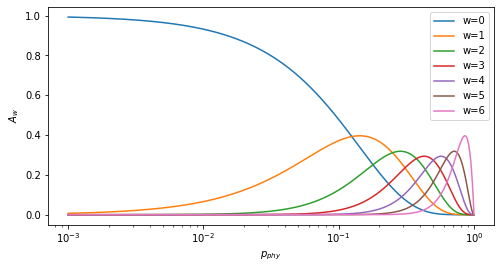

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

part = partition(ghz, GATE_GROUPS['p'])
Aw = np.array([[math.binom(w, len(part)+1, p) for p in p_phy] for w in range(len(part)+1)])
plt.figure(figsize=(8,4))
plt.plot(p_phy, Aw.T, label=[f'w={i}' for i in range(len(part)+1)]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

As we see, the `w=0` fault-weight subset is sampled by far most often for smaller rates. However, for this subset we know in advance that no logical failure can occur. Thus, we gain a lot by excluding it from the sampling process. Futhermore, for fault-tolerant circuits, we can be sure that even the `w=1` subset results in no logical failure, as we are guaranteed that the circuit is able to correct any error upto `w=1`. To achieve this importance sampling we create a new type of sampler which we call `SubsetSampler`.

**UNDER CONSTRUCTION: PLEASE DON'T USE SUBSET SAMPLER AT THE MOMENT**

For the `SubsetSampler` we want to sample from specific fault-weight-subsets upto a certain maximum weight $w_{max}$. The benefit of this approach is that we can scale each of the resulting failure rates by analytically calculated `subset_occurances` for each `p_phy` which then gives us `p_L(p_phy)` for all `p_phy` without any additional sampling required. The subset sampler chooses the next fault-weight subset that is used when sampling from the next circuit in the protocol by the minimum sampled subset for a given circuit, which results in a balanced sampling over all subsets for a circuit. Additionally, one can exclude sampling for all circuits in a protocol from certain subsets by specifying a *list of ints* of `w_exclude` fault-weights. Overall, this approach of choosing the subsets and defining the weight threshold is not ideal. The dynamic subset sampler includes methods to improve on both of these points.

In [ ]:
#export
class SubsetSampler(Sampler):
    """Subset Sampler of quantum protocols"""
    
    # def __init__(self, protocol, err_params):
    #     super().__init__(protocol, err_params)
        # self.fault_gens = map_dict(protocol._circuits, lambda _,circuit: DepolarSS(len(circuit)))
    
    @staticmethod
    def analytics(circuits, w_maxs, sample_range, err_params, w_exclude={}):
        w_exclude = set((w,) if isinstance(w,int) else w for w in w_exclude)
        w_maxs = [w_maxs] if isinstance(w_maxs, int) else w_maxs

        # circuits = self.protocol._circuits
        w_upto_w_maxs = {c_hash: [tuple(range(w_max+1)) for w_max in w_maxs] for c_hash in circuits.keys()} # order [p1,p2,..]
        w_vecs = remap(w_upto_w_maxs, lambda _,w_list: [w_vec for w_vec in it.product( *w_list ) if w_vec not in w_exclude])
        
        # self.p_phy_per_partition = np.vstack(list(err_params.values())).T
        # partitions = {c_hash: [partition(circuit, GATE_GROUPS[k]) for ] }
        p_phy_per_partition = np.array([[x * scalar for x in sample_range] for scalar in err_params.values()]).T
        Aws = remap(w_vecs, lambda c_hash, w: calc_subset_occurances(partitions[c_hash], w, p_phy_per_partition))
        
        
        # w_vecs = map_dict(w_upto_w_maxs, lambda _,w_list: [w_vec for w_vec in it.product( *w_list ) if w_vec not in w_exclude])
        # Aws = map_dict(w_vecs, lambda c,w: calc_subset_occurances(self.partitions[c], w, self.p_phy_per_partition))
        return Aws, w_vecs
    
    # def run(self, n_samples, w_max, w_exclude={}, var=math.Wilson_var, eval_fns=None):
    def run(self, n_samples, sample_range, err_params, w_max, w_exclude={}, var=math.Wilson_var, eval_fns={}):
         
        # Aws, w_vecs = self.analytics(w_max, sample_range, err_params, w_exclude)
        circuits = self.protocol._circuits
        Aws, w_vecs = SubsetSampler.analytics(circuits, w_max, sample_range, err_params, w_exclude)
        
        d = {n:c for n,c in self.protocol.nodes.data("circuit_hash", default=None) if c}
        visited_cnts    = map_dict(d, lambda _,c_hash: np.zeros(len(w_vecs[c_hash])))
        transition_cnts = map_dict(d, lambda node,c_hash: {s: np.zeros(len(w_vecs[c_hash])) for s in self.protocol.successors(node)})
                
        for _ in range(n_samples):
            hist = [] # track all (node,weight)s for a protocol run
            p_it = iterate(self.protocol, eval_fns)
            node = next(p_it)
            sim = self.simulator(self.n_qubits_in_protocol)
            
            while node:
                if node == "EXIT":
                    break
                else:
                    circuit_hash = self.protocol.circuit_hash(node)
                    w_idx = visited_cnts[node].argmin() # balanced weight selector
                    w = w_vecs[circuit_hash][w_idx]
                    hist.append((node,w_idx))
                    msmt = self._sample(sim, circuit_hash, w)
                    visited_cnts[node][w_idx] += 1
                    _node = node # store prev node
                    node = p_it.send(msmt) # exchange with iterator
                    if node: # None: insignificant exit -> no transition
                        transition_cnts[_node][node][w_idx] += 1  
        
        # Calculate statistics
        
        pws = {n: {succ: tcnts / visited_cnts[n] for succ,tcnts in ntrans.items()} for n,ntrans in transition_cnts.items()} 
        unpack_node = lambda n: n if not isinstance(n,(tuple,list,set)) else n[0]
        
        # p_L
        fail_paths = list(nx.all_simple_paths(self.protocol, 'START', 'EXIT'))
        Aws_wo_excl, w_vecs_wo_excl = SubsetSampler.analytics(circuits, w_maxs, sample_range, err_params, {})
        p_L_up, p_L_low = 0, 0
        for path in fail_paths:
            p_L_up_prod_acc = 1
            p_L_low_prod_acc = 1
            for i in range(1,len(path)-1):
                node, succ_node = path[i:i+2]
                circuit_hash = self.protocol.circuit_hash(node)
                pw = np.sum([Aws[circuit_hash][w] * pws[node][succ_node][w] for w in range(len(w_vecs[circuit_hash]))], axis=0)
                deltas = 1 - np.sum([Aws_wo_excl[circuit_hash][w] for w in range(len(w_vecs_wo_excl[circuit_hash]))], axis=0)
                p_L_low_prod_acc *= pw
                p_L_up_prod_acc *= (pw + deltas)
            p_L_up += p_L_up_prod_acc
            p_L_low += p_L_low_prod_acc
            
        # v_L
        v_L = 0
        for n1, p_to in pws.items(): # for every node in pws
            c_hash = self.protocol.circuit_hash(n1)
            for succ_node, ps in p_to.items(): # get the pws
                for w_idx, pw in enumerate(ps): # get pw per node
                    
                    vw = var(pw, visited_cnts[n1][w_idx]) # calc. V[pw]
                    Aw = Aws[c_hash][w_idx] # calc. Aw for a single node
                    
                    sum_acc = 0 # sum over all fail paths
                    for path in fail_paths:
                        prod_acc = 1
                        for i in range(1,len(path)-1): # all nodes in a fail path
                            n2, n2_succ = path[i:i+2] 
                            if n1 != n2: 
                                c_hash2 = self.protocol.circuit_hash(n2)
                                prod_acc *= np.sum([Aws[c_hash2][w] * pws[n2][n2_succ][w] for w in range(len(w_vecs[c_hash2]))], axis=0)
                        sum_acc += prod_acc
                        
                    v_L += vw * Aw**2 * sum_acc**2
                    
        return p_L_up, p_L_low, np.sqrt(v_L)

In [ ]:
#slow
# p = np.logspace(-3,0,10)
# err_params = {'p': 1}

# sam = SubsetSampler(ghz1, CHP)
# p_L_up,p_L_low,ss_std = sam.run(n_samples=1000, sample_range=p, err_params=err_params, w_max=2) # w_max is applied to all circuits in the protocol

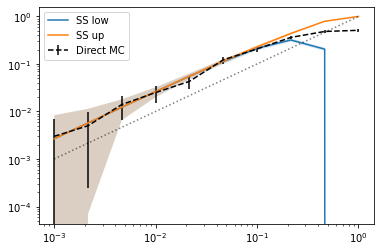

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

We can see that the results from both samplers match pretty well. For the `SubsetSampler` we obtain an upper and a lower bound. The difference is that for the subset sampler we used **a lot** less samples. Not only the `n_samples` parameter is much lower, but also does the sampling only take place **once** and not for each $p_{phy}$ as for the `Sampler`. However, the subset sampling approach is still not ideal. One way we can see this is by looking at the still relatively large variance at lower error rates. We can do better by implementing two additional features:
1. Including a function to dynamically choose the next circuit's subset weight to sample from such that the global variance $V_L$ is reduced most.
2. A method to choose all subset weights for each circuit which we want to include in the sampling process, s.t. its overall occurance is smaller than a user-defined threshold $\chi_{min}$.<br>

These features are introduced in the `DynamicSubsetSampler`.

# Multi-parameter/partition noise
It is more realistic to give the different partitions, i.e. 1-qubit or 2-qubit gates etc., different physical error rates. Similarly to the single-parameter case we can take a look at the occurance of the 2-partition-subsets:

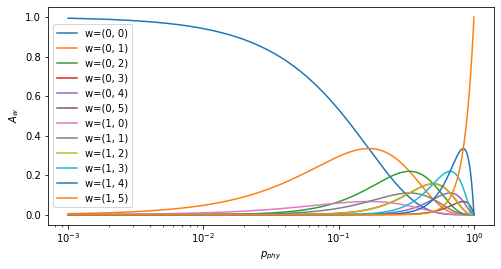

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

err_params = {'p1':p_phy, 'p2':p_phy}
partitions = [partition(ghz, GATE_GROUPS[g]) for g in err_params.keys()]
p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
w_max_vec = [len(p) for p in partitions]
w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec]
w_vecs = list(it.product( *w_upto_w_maxs ))
Aws = calc_subset_occurances(partitions, w_vecs, p_phys_mat)

plt.figure(figsize=(8,4))
plt.plot(p_phy, Aws.T, label=[f'w={i}' for i in w_vecs]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

As we can see the `(0,0)` subset has the largest impact for decreasing physical error rates. Thus we gain a lot by excluding it. This is how we run the subset sampler with multi-parameter noise and by manually excluding a subset.

In [ ]:
#slow
p1 = np.logspace(-3,0,10)
p2 = 0.5 * p1
err_params = {'p1': p1, 'p2': p2}

sam = SubsetSampler(ghz1, err_params)
p_L_up, p_L_low, ss_std = sam.run(n_samples=1000, w_max=[1,3], w_exclude=[(0,0)])

sam = Sampler(ghz1, err_params)
p_L, std = sam.run(n_samples=10000)

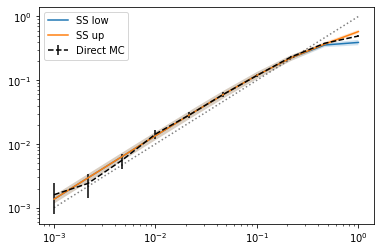

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

plt.errorbar(p1, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p1, p_L_low, label="SS low")
plt.fill_between(p1, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p1, p_L_up, label="SS up")
plt.fill_between(p1, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p1, p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

Manual exclusion of the `(0,0)`-subset also drastically reduces the variance at low error rates. This is due to the way we calculate the variance (by using the *Wilson interval*, which is non-zero even if $p=0$).

In [ ]:
#export
#hide

def calc_w_max(p_max, delta_max, n_partition_elems):
    """Calculate weight cutoff at p_max for delta_max"""
    
    delta = 1
    for w_max in range(n_partition_elems+1):
        delta -= math.binom(w_max, n_partition_elems, p_max)
        if delta < delta_max: 
            break
    return w_max

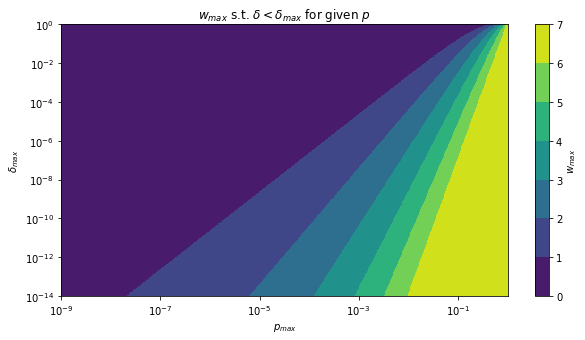

In [ ]:
#slow
#hide

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc_w_max(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()